# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>



Ouissal, Salima, Alexandre, Idriss, Elias

## Modules

In [35]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
import pandas as pd
import random
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Module csv
import csv

## Préprocessing des données

Pour la suite de notre étude, on considère le modèle d'avion **Airbus A320**, qui dispose de **174** sièges. (La classe businees n'est pas prise en compte)


<img src="modele_avion.jpg" alt="Modèle de l'avion" width="400" height="600">

In [36]:
# Load the Excel file into a pandas DataFrame

df_21Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [37]:
# On choisit la df sur laquelle on va travailler

df = df_21Oct
# df = df_22Oct
# df = df_23Oct
# df = df_24Oct
# df = df_30Oct
# df = df_05Nov
# df = df_07Nov

In [38]:
# Groups : dict[int : List[int]]

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0
transit_times= set()
for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                transit_time = group[5].hour*60 + group[5].minute
                Passagers[i] = {'gender': j-2, 'group': group[1], 'transit': float('inf')}
                if transit_time != 0 and transit_time < 121:
                    Passagers[i]['transit'] = transit_time
                    transit_times.add(transit_time)  # Add to the list, keeping duplicates if any
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    

Passagers

{1: {'gender': 1, 'group': 1, 'transit': 75},
 2: {'gender': 0, 'group': 2, 'transit': inf},
 3: {'gender': 1, 'group': 3, 'transit': inf},
 4: {'gender': 0, 'group': 4, 'transit': inf},
 5: {'gender': 1, 'group': 5, 'transit': inf},
 6: {'gender': 1, 'group': 5, 'transit': inf},
 7: {'gender': 0, 'group': 6, 'transit': inf},
 8: {'gender': 0, 'group': 7, 'transit': inf},
 9: {'gender': 0, 'group': 8, 'transit': 80},
 10: {'gender': 1, 'group': 8, 'transit': 80},
 11: {'gender': 1, 'group': 9, 'transit': inf},
 12: {'gender': 0, 'group': 10, 'transit': inf},
 13: {'gender': 0, 'group': 11, 'transit': inf},
 14: {'gender': 1, 'group': 11, 'transit': inf},
 15: {'gender': 1, 'group': 12, 'transit': 70},
 16: {'gender': 1, 'group': 13, 'transit': inf},
 17: {'gender': 0, 'group': 14, 'transit': inf},
 18: {'gender': 1, 'group': 14, 'transit': inf},
 19: {'gender': 1, 'group': 15, 'transit': inf},
 20: {'gender': 1, 'group': 16, 'transit': 95},
 21: {'gender': 0, 'group': 17, 'transit': 60

In [39]:
Groups = dict()

for i, passager in Passagers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]
for i in range(1,len(df)+1):
    if len(Groups[i]) ==1: del(Groups[i])
Groups

{5: [5, 6],
 8: [9, 10],
 11: [13, 14],
 14: [17, 18],
 17: [21, 22],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 23: [35, 36],
 24: [37, 38],
 27: [41, 42],
 31: [46, 47],
 34: [50, 51],
 35: [52, 53],
 39: [57, 58],
 45: [64, 65],
 51: [71, 72],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 59: [83, 84],
 61: [86, 87],
 63: [89, 90],
 65: [92, 93, 94],
 68: [97, 98],
 71: [101, 102],
 77: [108, 109],
 87: [119, 120],
 92: [125, 126],
 95: [129, 130],
 103: [138, 139],
 104: [140, 141],
 108: [145, 146],
 109: [147, 148],
 110: [149, 150]}

In [40]:
# Number of rows and columns per row based on the airplane configuration
number_of_seats = 174
number_of_rows = 29  # Rows are 1-indexed from 1 to 29
seats_per_row = 6    # 6 seats per row (0,1,2,3,4,5)
number_of_seats = 174
weight_f = 70 # weight female
weight_m = 85 # weight male
weight_d = 92.5 # weight disabled

## Initialize the model

In [41]:
m = Model("airplane_seating")

# Weights is a dictionary mapping (i, j, k) to a weight, as discussed earlier

# Create decision variables for each seat and passenger
# The decision variable x will be a 3D dictionary with the keys being the row number,
# the seat within the row, and the unique identifier for each passenger.

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, seats_per_row + 1)
                    for k in range(1, len(Passagers)+1)}

# Create AdjacentVarDict only for pairs of passengers in the same group and not the same person
AdjacentVarDict = {
    (i1, j1, k1, k2): m.addVar(vtype=GRB.BINARY, name=f'adjacent_{i1}_{j1}_{k1}_{k2}')
    for i1 in range(1, number_of_rows + 1)
    for j1 in range(1, seats_per_row + 1)
    for k1 in Passagers.keys()
    for k2 in Passagers.keys()
    if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
}


## Constraints on AssignmenVarDict

In [42]:
# Each passenger has a seat
SEATSASSIGNMENTCONST = m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                             for i in range(1, number_of_rows + 1)
                                             for j in range(1, seats_per_row + 1)
                                             for k in range(1,len(Passagers)+1)]) == len(Passagers))


In [43]:
# Each passenger must have one seat
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, seats_per_row + 1) ]) == 1)
                                                for k in range(1,len(Passagers)+1) }


In [44]:
# # Every seat is allocated to a single passenger
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passagers)+1)])<=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, seats_per_row+1)  }

In [45]:
# Constraint Airplane Centrage

i_m = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])
i_f = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])
i_d = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_m * number_m + weight_f * number_f + weight_d * number_d)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])
j_f = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])
j_d = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_m * number_m + weight_f * number_f + weight_d * number_d)

IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 4)
JMINBARYCONST = m.addConstr(3 <= j_bary)

In [46]:
# Constraints for the Disabled to be placed in front and in a certain way
DISABLEDCONSTR = m.addConstr(quicksum( [AssignmenVarDict[(i, j, k)] + AssignmenVarDict[(i, j-1, k)] + AssignmenVarDict[(i+1, j-1, k)] + AssignmenVarDict[(i+1, j, k)]
                      for i in range(1, number_of_rows)
                      for j in range(2, seats_per_row+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['gender'] == 2 ])<=1)

## Constraints on AssignmenProdDict

In [47]:
# Add constraints for the AdjacentVarDict to enforce the adjacency condition
for i1 in range(1, number_of_rows + 1):
    for j1 in range(1, seats_per_row + 1):
        for k1 in Passagers.keys():
            for k2 in Passagers.keys():
                if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2:
                    m.addConstr(AdjacentVarDict[(i1, j1, k1, k2)] <= AssignmenVarDict[(i1, j1, k1)])
                    m.addConstr(AdjacentVarDict[(i1, j1, k1, k2)] <= 
                                (AssignmenVarDict.get((i1-1, j1, k2), 0) +
                                 AssignmenVarDict.get((i1+1, j1, k2), 0) +
                                 AssignmenVarDict.get((i1, j1-1, k2), 0) +
                                 AssignmenVarDict.get((i1, j1+1, k2), 0)))
                    m.addConstr(AdjacentVarDict[(i1, j1, k1, k2)] >= 
                                AssignmenVarDict[(i1, j1, k1)] - 
                                (1 - AssignmenVarDict.get((i1-1, j1, k2), 0) -
                                     AssignmenVarDict.get((i1+1, j1, k2), 0) -
                                     AssignmenVarDict.get((i1, j1-1, k2), 0) -
                                     AssignmenVarDict.get((i1, j1+1, k2), 0)))

## Objective Function

In [48]:
# Objective function to minimize the weighted sum of distances between all passengers in the same group
objective_groups = quicksum([AdjacentVarDict[(i1, j1, k1, k2)]
    for i1 in range(1, number_of_rows + 1)
    for j1 in range(1, seats_per_row + 1)
    for k1 in Passagers.keys()
    for k2 in Passagers.keys()
    if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2]
)

# Front rows (lower i) should have lower weight
objective_transit = quicksum( [AssignmenVarDict[(i, j, k)]* i*(1/Passagers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, seats_per_row+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['transit'] != float('inf') and Passagers[k]['transit'] < 121 ])

# m.setObjective(objective_transit, GRB.MINIMIZE)
m.setObjective((-1)*objective_groups, GRB.MINIMIZE)

## Optimize Model

In [49]:
# Run optimization and suppress output
m.params.outputflag = 0 
m.update()
m.optimize()

# If the model is infeasible or unbounded, turn off presolve and optimize again
if m.status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

# Post-processing of results
if m.status == GRB.OPTIMAL:
    # Post-processing of results
    # Extract the seating arrangement from the model
    seating_arrangement = {}
    for i in range(1, number_of_rows + 1):
        for j in range(1, seats_per_row + 1):
            for k in Passagers.keys():
                if AssignmenVarDict[(i, j, k)].X > 0.5:  # Ensure the variable is part of the solution
                    seating_arrangement[(i, j)] = k
    print(f"Seating arrangement: {seating_arrangement}")
    print(f'Optimal objective value (z*): {round(m.objVal, 2)}')
else:
    print("Optimization was unsuccessful. Status code:", m.status)
    m.computeIIS()
    m.write("model.ilp")
    print("The infeasibility file has been written to 'model.ilp'")

Seating arrangement: {(1, 2): 148, (1, 3): 39, (1, 4): 76, (1, 5): 73, (1, 6): 26, (2, 1): 15, (2, 2): 7, (2, 3): 29, (2, 4): 99, (2, 5): 103, (2, 6): 97, (3, 1): 34, (3, 2): 24, (3, 4): 64, (3, 5): 31, (3, 6): 54, (4, 1): 52, (4, 2): 104, (4, 3): 61, (4, 5): 65, (4, 6): 114, (5, 1): 151, (5, 2): 43, (5, 3): 110, (5, 4): 111, (5, 5): 116, (6, 1): 48, (6, 2): 112, (6, 3): 121, (6, 4): 71, (6, 5): 119, (6, 6): 14, (7, 1): 69, (7, 2): 30, (7, 3): 118, (7, 4): 101, (7, 5): 56, (7, 6): 117, (8, 1): 149, (8, 3): 22, (8, 4): 42, (8, 5): 59, (8, 6): 55, (9, 1): 146, (9, 3): 74, (9, 4): 57, (9, 5): 18, (9, 6): 82, (10, 1): 75, (10, 2): 131, (10, 3): 86, (10, 4): 8, (10, 5): 23, (11, 1): 145, (11, 2): 72, (11, 5): 126, (11, 6): 70, (12, 1): 98, (12, 2): 11, (12, 3): 3, (12, 4): 6, (12, 6): 51, (13, 1): 41, (13, 2): 1, (13, 3): 140, (13, 4): 83, (13, 5): 27, (13, 6): 58, (14, 1): 16, (14, 2): 47, (14, 3): 13, (14, 4): 38, (14, 6): 10, (15, 2): 87, (15, 3): 66, (15, 4): 20, (15, 5): 68, (15, 6): 1

In [50]:
# def mycallback(model, where):
#     if where == GRB.Callback.MIP:
#         # Check the current iteration count
#         iteration_count = model.cbGet(GRB.Callback.MIP_ITRCNT)
        
#         if iteration_count % 100 == 0:
#             # Get the current best objective function value
#             objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
            
#             # Initialize an empty seating arrangement
#             seating_arrangement = {}
            
#             # Loop over all variables and get their assignments if they are part of the current best solution
#             for var in model.getVars():
#                 if var.varName.startswith('assign') and var.x > 0.5:
#                     _, i, j, k = var.varName.split('_')  # Adjust splitting based on your variable naming convention
#                     seating_arrangement[(int(i), int(j))] = k
            
#             # Print the current best objective value and seating arrangement
#             print(f'Iteration {iteration_count}')
#             print(f'Current best objective value (z*): {objbst}')
#             print(f"Seating arrangement: {seating_arrangement}")

# # Set the callback function
# m.setParam(GRB.Param.Presolve, 0)
# m.setParam(GRB.Param.OutputFlag, 0)
# m.update()

# # Pass the callback function to the model
# m.optimize(mycallback)

In [51]:
mising = []

for i in range(0,max(seating_arrangement.values())):
    if i not in seating_arrangement.values():
        mising.append(i)

print(sorted(mising))

[0]


## Graphic Seating Arrangement

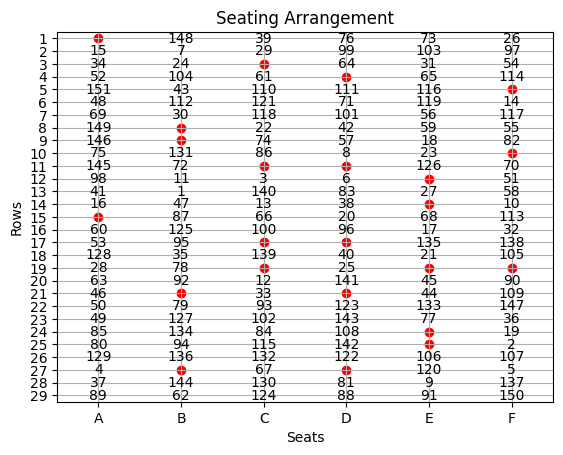

In [52]:
# Define the dimensions of the airplane
number_of_rows = 29
seats_per_row = 6

# Define the seating arrangement
seating_arrangement = seating_arrangement

# Create a plot
fig, ax = plt.subplots()

# Plot the seating arrangement
for seat, Passengers in seating_arrangement.items():
    ax.text(seat[1], seat[0], Passengers, ha='center', va='center')

# Mark positions without passengers
for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        if (i, j) not in seating_arrangement:
            ax.scatter(j, i, color='red')

# Set the limits and labels of the plot
ax.set_xlim(0.5, seats_per_row + 0.5)
ax.set_ylim(0.5, number_of_rows + 0.5)
ax.set_xticks(range(1, seats_per_row + 1))
ax.set_yticks(range(1, number_of_rows + 1))
ax.set_xticklabels([chr(65 + i) for i in range(seats_per_row)]) # permet de générer les lettres A,B,C,D,E,F grâce à chr()
ax.set_yticklabels(range(1, number_of_rows + 1))
ax.grid(True)

# Add labels and title
plt.xlabel('Seats')
plt.ylabel('Rows')
plt.title('Seating Arrangement')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to match the plane layout
plt.show()


In [53]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()

In [54]:
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[i]

In [55]:
data1 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passagers[k]['transit']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['transit']!=float('inf'): colors2[i-1][j-4] = color_transit[Passagers[k]['transit']]

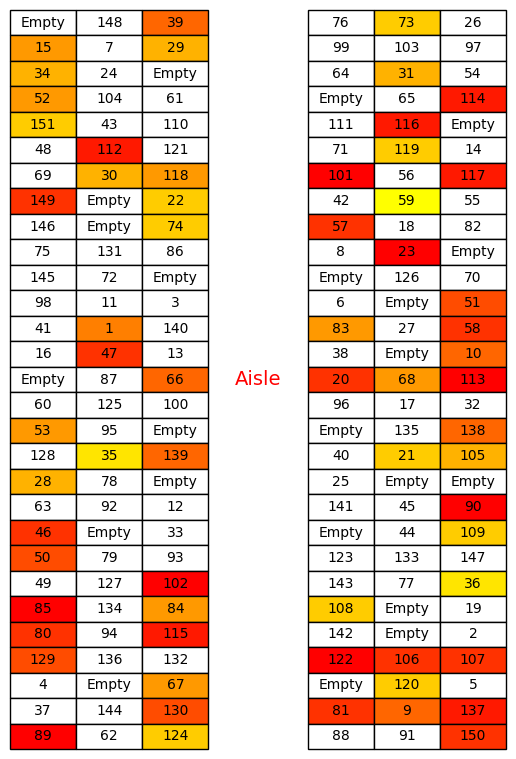

In [56]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Représentation Groupes

In [57]:
def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

In [58]:
graduation = generate_random_colors(len(Groups))
color_group = {i : graduation[i-1] for i in range(1, len(Groups)+1)}

In [59]:
data1 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(seats_per_row//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passagers[k]['group']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['group'] in color_group: colors2[i-1][j-4] = color_group[Passagers[k]['group']]

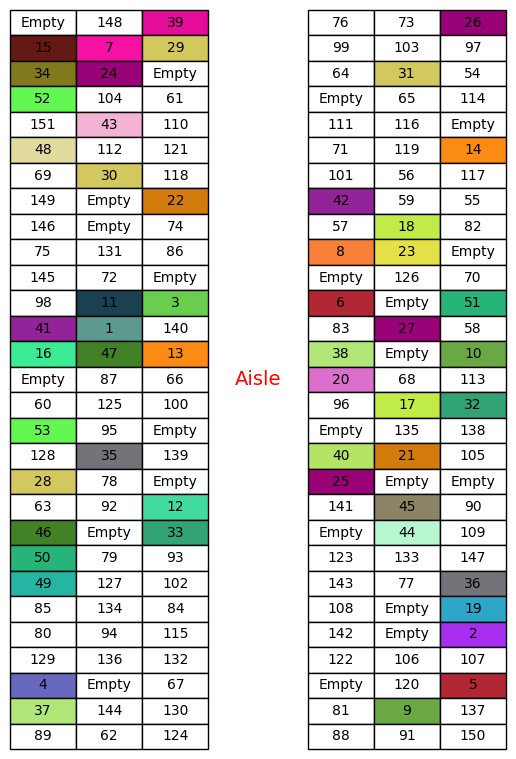

In [60]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()